In [49]:
import numpy as np
import pandas as pd
import math
import emcee
import numpy.random as rand
import scipy
from emcee import PTSampler
from scipy.stats import binom as binomial
from scipy.stats import gamma
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm
from ipywidgets import FloatProgress
from IPython.display import display
import sys
import pickle
from scipy.stats import beta as betafunction
%matplotlib inline



Take data from MSIRV simulation and generate data that is like that collected from DRC.

In [50]:
#Read in all the csv's. Filenames are self-explanatory.
ages_pd = pd.read_csv('../data/DRC_urban_All_Compartments/age_classes_in_months.csv')
MI_pd = pd.read_csv('../BrianSim/DRC_Coverage50_100yrs/DRC_urban_MaternallyImmune_Deterministic_Cov50_100yrs.csv')  
R_pd = pd.read_csv('../BrianSim/DRC_Coverage50_100yrs/DRC_urban_Recovered_Deterministic_Cov50_100yrs.csv')
V_pd = pd.read_csv('../BrianSim/DRC_Coverage50_100yrs/DRC_urban_Vaccinated_Deterministic_Cov50_100yrs.csv')
S_pd = pd.read_csv('../BrianSim/DRC_Coverage50_100yrs/DRC_urban_Susceptible_Deterministic_Cov50_100yrs.csv')
C_pd = pd.read_csv('../BrianSim/DRC_Coverage50_100yrs/DRC_urban_Cases_Deterministic_Cov50_100yrs.csv')

In [51]:
#Convert to numpy arrays for ease of manipulation.
agesall = ages_pd.as_matrix()

MIall = MI_pd.as_matrix()
Vall = V_pd.as_matrix()
Sall = S_pd.as_matrix()
Call = C_pd.as_matrix()
Rall = R_pd.as_matrix()

TotPall = MIall+Vall+Sall+Call+Rall

In [52]:
ages = agesall.copy()
V = Vall[:,-24:].copy()     #Vaccinated
MI = MIall[:,-24:].copy()   #Maternally immune
S = Sall[:,-24:].copy()     #Susceptible
C = Call[:,-24:].copy()     #Case
R = Rall[:,-24:].copy()     #Recovered
TotP = V+MI+S+C+R           #Total population

(0, 22)

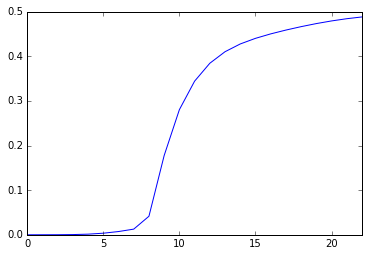

In [53]:
#Probability of being vaccinated as function of age - measured at end of year.
probv =  V[:,-1]/TotP[:,-1]
plt.plot(probv)
plt.xlim(0,22)

(0, 60)

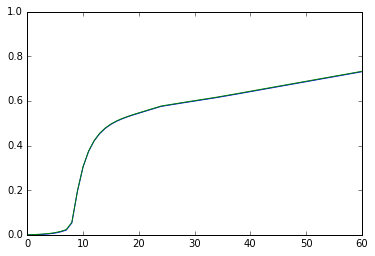

In [54]:
#Probability of being seropostive is probability of being in V or R. Also measured at end of year.
VRC = V[:,-1]+R[:,-1]+C[:,-1] #(Technically also includes cases but this term is irrelevant)
VR =  V[:,-1]+R[:,-1]
probsp = VR/TotP[:,-1]
probtest = VRC/TotP[:,-1]
plt.plot(probsp) 
plt.plot(probtest)
plt.xlim(0,60)

(225,)


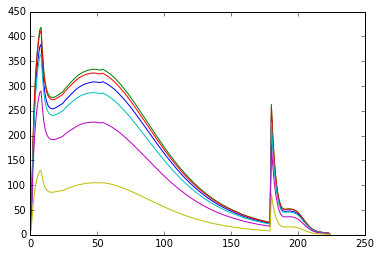

In [55]:
#Total cases is summed over the year
TotC = np.sum(C,axis=-1)
print np.shape(TotC)
plt.plot(C[:,3:8])
plt.plot(C[:,-1]) #That spike is where the age classes get wider - don't worry about it.

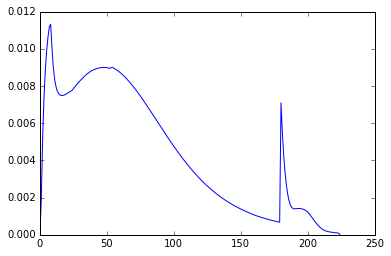

In [56]:
#Probability of being a case over the whole year:
probc = TotC/np.sum(TotC)
plt.plot(probc)
plt.savefig("caseprob.png")

In [57]:
#Need to bin up the case probabilities into 12-month chunks.
agemonths = ages[:,1].copy()
ageyears = np.linspace(1,720/12,720/12)
agemy = agemonths/12
probcyears = zip(agemy,probc)
probcyears = np.array(probcyears)

pcysum = np.zeros(len(ageyears))
i=0
for a in ageyears:
    if a<15:
        mask = probcyears[:,0]==a-1.
        dage = 1.
    if a==15:
        Tval1 = probcyears[:,0]==a-1
        Tval2 = probcyears[:,0]==a
        mask = [any(tup) for tup in zip(Tval1, Tval2)] 
        dage = 1.
    if a>15:
        mask = probcyears[:,0]==a
        dage = 1.
    hold = probcyears[mask,1]
    pcysum[i] = np.sum(hold)*dage
    i +=1

In [58]:
#Generate data according to these probabilities. Use Katanga-like sampling.
vt = [22, 18, 23, 26, 29, 29, 26, 29, 19, 21, 15, 17, 32, 13, 19, 16, 14,
       26, 19, 14, 20, 18, 15, 11, 16, 15, 19, 28, 21, 22, 21, 19, 13, 19,
       10, 15, 19, 10, 12, 19, 18, 18, 28, 14, 15, 16, 19, 14,  6, 12, 20,
       13, 19, 23, 18, 11, 15, 17, 13, 14]
st = [ 0,  0,  0,  0,  0,  0, 21, 29, 18, 20, 16, 17, 33, 12, 19, 17, 14,
       26, 20, 16, 19, 18, 17, 11, 19, 19, 19, 28, 22, 25, 21, 19, 15, 23,
        9, 16, 21, 14, 14, 21, 18, 20, 29, 20, 16, 22, 22, 15, 10, 14, 21,
       14, 18, 23, 21, 15, 14, 21, 14, 18]
ct = [541, 619, 399, 314, 177, 158, 122,  80,  61,  35,  24,  25,  14,
        17,  11,  12,   2,   3,   2,   3,   1,   1,   1,   0,   2,   3,
         1,   3,   2,   3,   1,   1,   1,   0,   3,   1,   0,   0,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0]
vt = np.array(vt)
st = np.array(st)
ct = np.array(ct)

st += 10
vt += 10

total_cases = sum(ct)
print total_cases

2645


(225, 2)


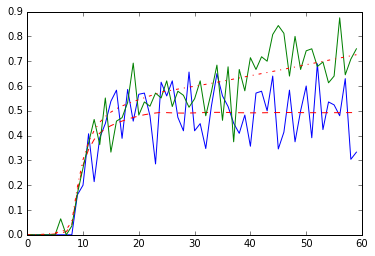

In [74]:
#seroprevalence and vaccination status are measured for the first 60 months:
vobs = np.zeros(60)
sobs = np.zeros(60)
veff = 1.
for i in range(60):
    vprob = probv[i]/veff 
    if vprob >1.:
        vprob = 1.
    vtest = vt[i]
    vobs[i] = np.random.binomial(vtest,vprob)
    sprob = probsp[i]
    stest = st[i]
    sobs[i] = np.random.binomial(stest,sprob)

plt.plot(vobs/vt)
plt.plot(probv[0:60],'r--')
plt.plot(sobs/st)
plt.plot(probsp[0:60],'r-.')
print np.shape(ages)

1.0
()


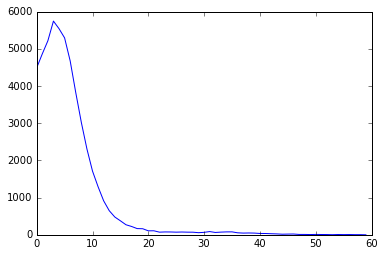

In [75]:
#cases should be distributed as a multinomial over 60 bins of 1 year:
cobs = np.random.multinomial(total_cases*20.,pcysum)
print sum(pcysum)
plt.plot(cobs)
print np.shape(vtest)

In [76]:
DataOut = np.vstack((vobs,vt,sobs,st,cobs))
DataOut = DataOut.T
print np.shape(DataOut)

(60, 5)


In [77]:
print np.shape(DataOut)
np.savetxt("FakeData50_veff1.0.csv",DataOut,delimiter=",")

(60, 5)
